# What we are studying and why:
I set out to look at mental health, and after exploring some initial data narrowed my focus to studying mental health alongside alcohol use pre- and post-pandemic.  Covid 19 brought isolation, job loss, fear about remaining healthy, grief for those lost and loss of access to resources and community. I expected an increase when comparing pre and post-pandemic data for depression and anxiety as well as an uptick in alcohol use in that timeframe as many use alcohol during periods of stress.

Alcohol use is closely linked to mental health. Increased alcohol consumption can influence depression and anxiety, and poor mental health can drive alcohol use. 

By comparing data sets for depression and alcohol use alongside demographic data from the National Health and Nutrition Examination Survey (NHANES) data library, I hope to uncover how different populations experienced challenges of covid 19, and whether some groups were more or less at risk of mental health struggles than others.
Insights from this research could help shape mental health and substance abuse policies in different regions. It could be useful for health tech businesses wanting to provide services in specific states or regions as well as for staffing and funding of crisis hotlines and substance abuse programs. 



## Data Justification 
NHANES provides trusted demographic and health data suitable for studying depression and alcohol use across different demographics.
It covers years 2017–2023 and which gives an ideal range for pre and post pandemic data. Reddit offers another picture, which highlights a non-clinical self report of alcohol use. While reddit data is likely biased toward younger and more tech savvy individuals, it may offer a more intimate look at alcohol use outside of a clinical setting. People may be more inclined to disclose thier struggles anonymously on reddit than to their doctors, especailly if they are not seeking medical help with addicion. 


### First, combine the demographic, alcohol and depression data from the pre and post pandemic periods into one set





In [116]:
!pip install pandas pyreadstat praw matplotlib nltk


In [2]:
import numpy as np
import pandas as pd
import os
from scipy.stats import ttest_ind
 

In [3]:
# File paths to years 2013-2023 for demographic, depression, and alcohol use surveys 
# from CDC website "National Health and Nutrition Examenation Survey"
file_paths = [
    "P_DPQ_2017-2020-pre.xpt", 
    "P_ALQ_2017-2020-pre.xpt", "P_DEMO_2017-2020-pre.xpt", 
    "DPQ_L_2021-2023.xpt",
    "ALQ_L_2021-2023.xpt", "DEMO_L_2021-2023.xpt"
]

# Load each file into dictionary of DataFrames
dataframes = {}
for file in file_paths:
    key = os.path.splitext(os.path.basename(file))[0]  # Use filename as key
    dataframes[key] = pd.read_sas(file, format="xport")

# Check loaded files
for key, df in dataframes.items():
    print(f"{key}: {df.shape}")


P_DPQ_2017-2020-pre: (8965, 11)
P_ALQ_2017-2020-pre: (8965, 10)
P_DEMO_2017-2020-pre: (15560, 29)
DPQ_L_2021-2023: (6337, 11)
ALQ_L_2021-2023: (6337, 9)
DEMO_L_2021-2023: (11933, 27)


In [4]:
# Merge 2017-2020 files
dpq_2017 = dataframes['P_DPQ_2017-2020-pre']
alq_2017 = dataframes['P_ALQ_2017-2020-pre']
demo_2017 = dataframes['P_DEMO_2017-2020-pre']

# Merge using SEQN
merged_2017 = demo_2017.merge(dpq_2017, on="SEQN", how="inner") \
                       .merge(alq_2017, on="SEQN", how="left")                    

# Merge 2021-2023 files
dpq_2021 = dataframes['DPQ_L_2021-2023']
alq_2021 = dataframes['ALQ_L_2021-2023']
demo_2021 = dataframes['DEMO_L_2021-2023']

# Merge using SEQN
merged_2021 = demo_2021.merge(dpq_2021, on="SEQN", how="inner") \
                       .merge(alq_2021, on="SEQN", how="left") 

In [5]:
# Combine all year blocks
combined_df = pd.concat([merged_2017, merged_2021], ignore_index=True)

# Check combined dataset
print(combined_df.shape)
print(combined_df.head())

(15302, 59)
       SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  109266.0      66.0       2.0       2.0      29.0       NaN       5.0   
1  109271.0      66.0       2.0       1.0      49.0       NaN       3.0   
2  109273.0      66.0       2.0       1.0      36.0       NaN       3.0   
3  109274.0      66.0       2.0       1.0      68.0       NaN       5.0   
4  109282.0      66.0       2.0       1.0      76.0       NaN       3.0   

   RIDRETH3  RIDEXMON  DMDBORN4  ...  DMQMILIZ  DMDYRUSR  DMDHHSIZ  DMDHRGND  \
0       6.0       2.0       2.0  ...       NaN       NaN       NaN       NaN   
1       3.0       2.0       1.0  ...       NaN       NaN       NaN       NaN   
2       3.0       2.0       1.0  ...       NaN       NaN       NaN       NaN   
3       7.0       1.0       1.0  ...       NaN       NaN       NaN       NaN   
4       3.0       2.0       1.0  ...       NaN       NaN       NaN       NaN   

   DMDHRAGZ  DMDHREDZ  DMDHRMAZ  DMDHSEDZ  WTINT2YR  WTM

## But what the heck are all these codes?
The NHANES data was very comprehensive but required the use of codebooks that create consistency across the 2 year increments data is typically collected in. I matched the codebooks for 2021-23 alcohol, depression and demograpic data to the codes across the whole combined dataset to create a set of parameters that extends across all years pre and post-pandemic.

In [6]:
# Make original columns readable using codebooks
column_mapping = {
    'SEQN': 'Respondent sequence number',
    'SDDSRVYR': 'Data release cycle',
    'RIDSTATR': 'Interview/Examination status',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age in years at screening',
    'RIDAGEMN': 'Age in months at screening (0-24 months)',
    'RIDRETH1': 'Race/Hispanic origin',
    'RIDRETH3': 'Race/Hispanic origin with NH Asian',
    'RIDEXMON': 'Six-month time period',
    'RIDEXAGM': 'Age in months at exam (0-19 years)',
    'DMQMILIZ': 'Served active duty in US Armed Forces',
    'DMDBORN4': 'Country of birth',
    'DMDYRUSR': 'Length of time in US',
    'DMDEDUC2': 'Education level (Adults 20+)',
    'DMDMARTZ': 'Marital status',
    'RIDEXPRG': 'Pregnancy status at exam',
    'DMDHHSIZ': 'Total number of people in the household',
    'DMDHRGND': 'Household reference person’s gender',
    'DMDHRAGZ': 'Household reference person’s age in years',
    'DMDHREDZ': 'Household reference person’s education level',
    'DMDHRMAZ': 'Household reference person’s marital status',
    'DMDHSEDZ': 'Household reference person’s spouse’s education level',
    'WTINT2YR': 'Full sample 2-year interview weight',
    'WTMEC2YR': 'Full sample 2-year MEC exam weight',
    'WTINTPRP': 'Full sample interview weight',
    'WTMECPRP': 'Full sample MEC exam weight',
    'SDMVSTRA': 'Masked variance pseudo-stratum',
    'SDMVPSU': 'Masked variance pseudo-PSU',
    'INDFMPIR': 'Ratio of family income to poverty',
    'ALQ111': 'Ever had a drink of any kind of alcohol',
    'ALQ121': 'Past 12 months how often drink alcohol beverage',
    'ALQ130': 'Average number of alcoholic drinks/day in past 12 months',
    'ALQ142': 'Number of days had 4/5 drinks in past 12 months',
    'ALQ290': 'Times 12+ drinks in 1 day/past 12 mos',
    'ALQ270': 'Number of times had 4/5 drinks in 2 hours (past 12 months)',
    'ALQ280': 'Number of times had 8+ drinks in 1 day (past 12 months)',
    'ALQ151': 'Ever had 4/5 or more drinks every day',
    'ALQ170': 'Number of times had 4/5 drinks on occasion (past month)',
    'DPQ010': 'Little interest in doing things',
    'DPQ020': 'Feeling down, depressed, or hopeless',
    'DPQ030': 'Trouble sleeping or sleeping too much',
    'DPQ040': 'Feeling tired or having little energy',
    'DPQ050': 'Poor appetite or overeating',
    'DPQ060': 'Feeling bad about yourself',
    'DPQ070': 'Trouble concentrating on things',
    'DPQ080': 'Moving or speaking slowly or too fast',
    'DPQ090': 'Thought you would be better off dead',
    'DPQ100': 'Difficulty these problems have caused',
}

# Create anotehr DataFrame with readable columns
readable_df = combined_df.rename(columns=column_mapping)

#Check first few rows and ensure all cols are there 
print(readable_df.head())
print(readable_df.columns)

# make a new csv of combined data with readable names
readable_df.to_csv('nhanes_columns_readable.csv', index=False)

   Respondent sequence number  Data release cycle  \
0                    109266.0                66.0   
1                    109271.0                66.0   
2                    109273.0                66.0   
3                    109274.0                66.0   
4                    109282.0                66.0   

   Interview/Examination status  Gender  Age in years at screening  \
0                           2.0     2.0                       29.0   
1                           2.0     1.0                       49.0   
2                           2.0     1.0                       36.0   
3                           2.0     1.0                       68.0   
4                           2.0     1.0                       76.0   

   Age in months at screening (0-24 months)  Race/Hispanic origin  \
0                                       NaN                   5.0   
1                                       NaN                   3.0   
2                                       NaN          

### I saved this as a readable data frame

Comparing the codebooks for 2021-23 Alcohol, Depression and Demographics, a more readable data set can be created. Now I am able to make some decisions about which data can help with my research questions.


## Research Questions:
How have trends in mental health (specifically depression) evolved pre and post-pandemic?

Was there a related change in alcohol consumption during this period?

Did these changes differ over demographics like age, gender and race?

Does the pandemic impact the way alcohol addiction is discussed on social media (reddit r/stopdrinking, r/AskReddit)? 
## Hypotheses:
Depression and anxiety increased post-pandemic.

Alcohol use increased during the pandemic and may contribute to negative mental health.

Increased negative sentiment of alcohol on reddit after the pandemic.


## Next step:

I needed to clean up the data to use the most relevant info. I took the alcohol and dpression survey as well as demographics (age, gender, race) and the data years, weights for each set and sequence number

In [9]:
# keep only relevant variables
columns_needed = [
    'Respondent sequence number',
    'Data release cycle',
    'Little interest in doing things',
    'Feeling down, depressed, or hopeless',
    'Trouble sleeping or sleeping too much',
    'Feeling tired or having little energy',
    'Poor appetite or overeating',
    'Feeling bad about yourself',
    'Thought you would be better off dead',
    'Ever had a drink of any kind of alcohol',
    'Past 12 months how often drink alcohol beverage',
    'Average number of alcoholic drinks/day in past 12 months',
    'Number of days had 4/5 drinks in past 12 months',
    'Gender',
    'Age in years at screening',
    'Race/Hispanic origin',
    'Full sample 2-year interview weight',
    'Full sample 2-year MEC exam weight',
    'Masked variance pseudo-PSU',
    'Masked variance pseudo-stratum',
    'Full sample interview weight',
    'Full sample MEC exam weight',
]

subset_data = readable_df[columns_needed]

# make new CSV file 
subset_data.to_csv("mental_health_alcohol_data.csv", index=False)

# Dlook at first rows
subset_data.head()



,Respondent sequence number,Data release cycle,Little interest in doing things,"Feeling down, depressed, or hopeless",Trouble sleeping or sleeping too much,Feeling tired or having little energy,Poor appetite or overeating,Feeling bad about yourself,Thought you would be better off dead,Ever had a drink of any kind of alcohol,...,Number of days had 4/5 drinks in past 12 months,Gender,Age in years at screening,Race/Hispanic origin,Full sample 2-year interview weight,Full sample 2-year MEC exam weight,Masked variance pseudo-PSU,Masked variance pseudo-stratum,Full sample interview weight,Full sample MEC exam weight
0,109266.0,66.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,...,5.397605e-79,2.0,29.0,5.0,NaN,NaN,2.0,168.0,7825.646112,8154.968193
1,109271.0,66.0,2.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,...,NaN,1.0,49.0,3.0,NaN,NaN,1.0,167.0,8481.589837,8658.732873
2,109273.0,66.0,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,5.397605e-79,1.0,...,NaN,1.0,36.0,3.0,NaN,NaN,1.0,155.0,20171.847767,22163.596850
3,109274.0,66.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,...,5.000000e+00,1.0,68.0,5.0,NaN,NaN,2.0,167.0,7227.993241,7801.600218
4,109282.0,66.0,5.397605e-79,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.0,...,NaN,1.0,76.0,3.0,NaN,NaN,2.0,164.0,28363.015286,31816.346500


Check for different missing data and sort by how much is missing 


In [12]:
missing_summary = readable_subset.isnull().sum().sort_values(ascending=False)
missing_percent = (readable_subset.isnull().mean() * 100).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Count': missing_summary, 'Missing Percent': missing_percent})
print(missing_data)


                                                    Missing Count  \
Full sample 2-year interview weight                          8965   
Full sample 2-year MEC exam weight                           8965   
Full sample MEC exam weight                                  6337   
Full sample interview weight                                 6337   
Average number of alcoholic drinks/day in past ...           5370   
Number of days had 4/5 drinks in past 12 months              5357   
Past 12 months how often drink alcohol beverage              2877   
Thought you would be better off dead                         1494   
Feeling bad about yourself                                   1488   
Poor appetite or overeating                                  1484   
Feeling tired or having little energy                        1483   
Trouble sleeping or sleeping too much                        1480   
Feeling down, depressed, or hopeless                         1478   
Little interest in doing things   

In [13]:
# It seems missing weights have to do with the data release cycle
weight_missing_by_cycle = readable_subset.groupby('Data release cycle')[[
    'Full sample 2-year interview weight',
    'Full sample 2-year MEC exam weight',
    'Full sample MEC exam weight',
    'Full sample interview weight'
]].apply(lambda x: x.isnull().mean() * 100)
print(weight_missing_by_cycle)

                           Full sample 2-year interview weight  \
Data release cycle                                               
2017–2020 (Pre-Pandemic)                                 100.0   
2021–2023 (Post-Pandemic)                                  0.0   

                           Full sample 2-year MEC exam weight  \
Data release cycle                                              
2017–2020 (Pre-Pandemic)                                100.0   
2021–2023 (Post-Pandemic)                                 0.0   

                           Full sample MEC exam weight  \
Data release cycle                                       
2017–2020 (Pre-Pandemic)                           0.0   
2021–2023 (Post-Pandemic)                        100.0   

                           Full sample interview weight  
Data release cycle                                       
2017–2020 (Pre-Pandemic)                            0.0  
2021–2023 (Post-Pandemic)                         100.0  


This confirms the missing weights are due to differnt release cycles

## What are weights? 

Weights in survey data ensure that the results are representative of the population. They compensate for oversampling, non-responses, and differences in the probability of selection.

### How do we handle other missing data?

Data imputation is the process of replacing missing values in a dataset with estimated values using prediction methods. Depending on the charactersitics of the missing data there are different approaches 

#### Low to somewhat moderate missing data for alcohol survey
Number of days had 4/5 drinks in past 12 months:           **35%** \
Past 12 months how often drink alcohol beverage:           **18%**

#### Low missing data for depression survey:
Thought you would be better off dead                       **9.7%** \
Feeling bad about yourself                                 **9.7%** \
Poor appetite or overeating                                **9.6%** \
Feeling tired or having little energy                      **9.6%** \
Trouble sleeping or sleeping too much                      **9.6%** \
Feeling down, depressed, or hopeless                       **9.6%** \
Little interest in doing things                            **9.6%** \
Ever had a drink of any kind of alcohol                    **9.4%**
#### Data randomness 
Determining whether missing values are random or not is crucial for handling missing data appropriately. 
If missing values are randomly distributed across all variables, this suggests missing values are random.

In [14]:
# Create missingness indicators
cols_to_check = [
    'Number of days had 4/5 drinks in past 12 months',
    'Past 12 months how often drink alcohol beverage',
    'Thought you would be better off dead',
    'Feeling bad about yourself',
    'Poor appetite or overeating',
    'Feeling tired or having little energy',
    'Trouble sleeping or sleeping too much',
    'Feeling down, depressed, or hopeless',
    'Little interest in doing things',
    'Ever had a drink of any kind of alcohol'
]

for col in cols_to_check:
    readable_subset[f'{col}_missing'] = readable_subset[col].isnull()



In [15]:
# to avoid errors with age data in non numeric form
 
#Convert to Numeric Convert the Age in years at screening column to numeric, making any invalid entries to NaN (coerce)
readable_subset['Age in years at screening'] = pd.to_numeric(readable_subset['Age in years at screening'], errors='coerce')
print(readable_subset['Age in years at screening'].dtype)

float64


In [16]:
from scipy.stats import ttest_ind

for col in cols_to_check:
    missing_col = f'{col}_missing'
    
    group_missing = readable_subset.loc[readable_subset[missing_col], 'Age in years at screening']
    group_not_missing = readable_subset.loc[~readable_subset[missing_col], 'Age in years at screening']
    
    # Perform t-test
    t_stat, p_val = ttest_ind(group_missing.dropna(), group_not_missing.dropna(), nan_policy='omit')
    
    print(f"Column: {col}")
    print(f"T-statistic for Age: {t_stat:.4f}, P-value: {p_val:.4f}")
    print("-" * 40)


Column: Number of days had 4/5 drinks in past 12 months
T-statistic for Age: 14.6813, P-value: 0.0000
----------------------------------------
Column: Past 12 months how often drink alcohol beverage
T-statistic for Age: -5.2509, P-value: 0.0000
----------------------------------------
Column: Thought you would be better off dead
T-statistic for Age: -0.1689, P-value: 0.8659
----------------------------------------
Column: Feeling bad about yourself
T-statistic for Age: -0.1582, P-value: 0.8743
----------------------------------------
Column: Poor appetite or overeating
T-statistic for Age: -0.1999, P-value: 0.8416
----------------------------------------
Column: Feeling tired or having little energy
T-statistic for Age: -0.2253, P-value: 0.8217
----------------------------------------
Column: Trouble sleeping or sleeping too much
T-statistic for Age: -0.2696, P-value: 0.7875
----------------------------------------
Column: Feeling down, depressed, or hopeless
T-statistic for Age: -0.35

### Randomness Explained: 

A high absolute value of t-statistic means the difference is large compared to the variability.
A P-value < 0.05 means the difference is statistically significant and unlikely to have happened by chance.

**Alcohol Survey Questions**
The missingness in "Number of days had 4/5 drinks" and "Past 12 months how often drink alcohol beverage" is not random, as there is significant age difference in responses and this suggests a relationship between missingness and age. This could highlight biases in responses from different age groups.\
Since the missing data for alcohol is not random and is related to age, we shoudl use a regression model to predict the missing values. 
 
**Depression Survey Questions** 
The missingness in all depression-related variables appears to be random (MCAR), as there is no significant age difference between groups with and without missing data.


## A roadblock:

To understand the data in my combined dataset, I'd renamed all the columns and data to make them more readable. In doing this I lost the formatting. When I tried to run regression models to predict missing data, I found I was blocked by this. To resolve it I made a version of the narrowed data set using the old column keys and numeric values for the data so that I could perform modeling on the original data set while referring to a readable data set I could easily understand without constantly referring to the codebooks. I'm not sure whether medical data scientists memorise all the codes or not, but found this a more usable solution.

In [18]:
# back it up: 
# Reverse the column_mapping dictionary
reverse_mapping = {v: k for k, v in column_mapping.items()}

# Get original column names corresponding to the needed columns
needed_keys = [reverse_mapping[col] for col in columns_needed if col in reverse_mapping]

# Create a new DataFrame with only the needed columns
filtered_og = combined_df[needed_keys].copy()

# Display the new DataFrame
filtered_og.head()



,SEQN,SDDSRVYR,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ090,ALQ111,...,ALQ142,RIAGENDR,RIDAGEYR,RIDRETH1,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,WTINTPRP,WTMECPRP
0,109266.0,66.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,...,5.397605e-79,2.0,29.0,5.0,NaN,NaN,2.0,168.0,7825.646112,8154.968193
1,109271.0,66.0,2.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,...,NaN,1.0,49.0,3.0,NaN,NaN,1.0,167.0,8481.589837,8658.732873
2,109273.0,66.0,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,5.397605e-79,1.0,...,NaN,1.0,36.0,3.0,NaN,NaN,1.0,155.0,20171.847767,22163.596850
3,109274.0,66.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,...,5.000000e+00,1.0,68.0,5.0,NaN,NaN,2.0,167.0,7227.993241,7801.600218
4,109282.0,66.0,5.397605e-79,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.0,...,NaN,1.0,76.0,3.0,NaN,NaN,2.0,164.0,28363.015286,31816.346500


Now we have the combined and narrowed data set with the original values to do the imputations on 🥳 First set predictors and target columns to numeric and define them

In [53]:
# copy data to replacing missing 
data_to_impute = filtered_og.copy()

# make predictors and target columns numeric
data_to_impute['RIAGENDR'] = data_to_impute['RIAGENDR'].astype(float)
data_to_impute['RIDAGEYR'] = data_to_impute['RIDAGEYR'].replace(80, np.nan).astype(float)  # makes 80 like a missing value
data_to_impute['RIDRETH1'] = data_to_impute['RIDRETH1'].astype(float)

predictors = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1']
target_columns = ['ALQ142', 'ALQ121', 'ALQ130']


In [54]:

#Replaces missing values using a mean, median, or most frequent https://scikit-learn.org/1.5/modules/generated/sklearn.impute.SimpleImputer.html
from sklearn.impute import SimpleImputer
predictor_imputer = SimpleImputer(strategy='mean')

# Impute missing predictors with the mean
data_to_impute[predictors] = predictor_imputer.fit_transform(data_to_impute[predictors])


In [55]:
#https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression
import numpy as np

def impute_with_regression(data, target_col, predictors):
    # Split data into rows with and without missing target values
    data_non_missing = data.dropna(subset=[target_col])
    data_missing = data[data[target_col].isnull()]

    # Prepare training data
    X_train = data_non_missing[predictors]
    y_train = data_non_missing[target_col]

    # Fit regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict missing values
    X_missing = data_missing[predictors]
    data.loc[data[target_col].isnull(), target_col] = model.predict(X_missing)
    return data


In [56]:
# Impute missing values for target columns
for col in target_columns:
    data_to_impute = impute_with_regression(data_to_impute, col, predictors)


In [57]:
print("missing values:")
print(data_to_impute[target_columns].isnull().sum())


missing values:
ALQ142    0
ALQ121    0
ALQ130    0
dtype: int64


The alcohol missing data is now repaced. NExt let's look at the depression missing values


In [58]:
# Select columns for imputation
columns_for_knn = [
    'DPQ090', 'DPQ060', 'DPQ050', 'DPQ040', 
    'DPQ030', 'DPQ020', 'DPQ010', 'ALQ111',
    'RIDAGEYR', 'RIAGENDR', 'RIDRETH1'  
]

# Create a subset of the data
data_for_imputation = data_to_impute[columns_for_knn]


In [38]:
#https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_imputation)



In [39]:
#Use k nearest neighbor to impute https://scikit-learn.org/1.5/modules/generated/sklearn.impute.KNNImputer.html
from sklearn.impute import KNNImputer

# Initialize and fit the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)  # 5 neighbors
imputed_data = knn_imputer.fit_transform(scaled_data)

In [40]:
# inverse transform the data - restores the original scale of the data. 
imputed_data = scaler.inverse_transform(imputed_data)

In [72]:
# Update the original data with the KNN-imputed values
for col in columns_for_knn:
    data_to_impute[col] = imputed_data_df[col]

## Now I have a handled all missing data
 

In [73]:
# Check for missing values
missing_values_summary = data_to_impute.isnull().sum()
print("Missing values per column:")
print(missing_values_summary)

# Print total missing values
print(f"Total missing values: {missing_values_summary.sum()}")


Missing values per column:
SEQN           0
SDDSRVYR       0
DPQ010         0
DPQ020         0
DPQ030         0
DPQ040         0
DPQ050         0
DPQ060         0
DPQ090         0
ALQ111         0
ALQ121         0
ALQ130         0
ALQ142         0
RIAGENDR       0
RIDAGEYR       0
RIDRETH1       0
WTINT2YR    8965
WTMEC2YR    8965
SDMVPSU        0
SDMVSTRA       0
WTINTPRP    6337
WTMECPRP    6337
dtype: int64
Total missing values: 30604


## Next we create a weight column so we can use weights for the surveys
NHANES data uses weights to account for sampling design. NHANES uses stratified and clustered sampling to ensure diversity on the data. Weights prevent oversampling of certain groups and make sure the results reflect the population. More on weights here: https://wwwn.cdc.gov/nchs/nhanes/tutorials/weighting.aspx I have consolidated the two rows into one weights row for simplicity.

In [77]:
def assign_weight(row):
    if row['SDDSRVYR'] == 66.0:
        return row['WTINTPRP']  # 2017–2020
    elif row['SDDSRVYR'] == 12.0:
        return row['WTINT2YR']  # 2021–2023
    else:
        return np.nan

data_to_impute['Consolidated_Weight'] = data_to_impute.apply(assign_weight, axis=1)


In [78]:
print(data_to_impute.head())

       SEQN  SDDSRVYR  DPQ010  DPQ020  DPQ030  DPQ040        DPQ050  DPQ060  \
0  109266.0      66.0     0.0     0.0     0.0     0.0  5.551115e-17     0.0   
1  109271.0      66.0     2.0     1.0     0.0     0.0  5.551115e-17     0.0   
2  109273.0      66.0     2.0     2.0     2.0     2.0  2.000000e+00     2.0   
3  109274.0      66.0     0.0     0.0     0.0     0.0  5.551115e-17     0.0   
4  109282.0      66.0     0.0     1.0     0.0     1.0  5.551115e-17     0.0   

   DPQ090  ALQ111  ...  RIAGENDR  RIDAGEYR  RIDRETH1  WTINT2YR  WTMEC2YR  \
0     0.0     1.0  ...       2.0      29.0       5.0       NaN       NaN   
1     0.0     1.0  ...       1.0      49.0       3.0       NaN       NaN   
2     0.0     1.0  ...       1.0      36.0       3.0       NaN       NaN   
3     0.0     1.0  ...       1.0      68.0       5.0       NaN       NaN   
4     0.0     1.0  ...       1.0      76.0       3.0       NaN       NaN   

   SDMVPSU  SDMVSTRA      WTINTPRP      WTMECPRP  Consolidated_Weigh

## Exploring the data: 

Did depression and alcohol use patterns change between the two survey cycles? First let's group the data by cycle pre and post pandemic. I can use SDDSRVYR (year code) to split data into pre-pandemic (value = 66.0) and post-pandemic (value = 12.0) groups. We van calculate weighted Means using the Consolidated_Weight column for depression scores and alcohol use.


In [80]:
# cleaned data for plotting
cleaned_data = data_to_impute.copy()

# save `cleaned_data` as CSV 
cleaned_data.to_csv("cleaned_data.csv", index=False)

In [85]:
# Depression and alcohol columns
analysis_columns = [
    'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ090', 'ALQ130'
]

# Weighted averages by survey cycle
weighted_means = cleaned_data.groupby('SDDSRVYR').apply(
    lambda x: (x[analysis_columns].T @ x['Consolidated_Weight']) / x['Consolidated_Weight'].sum()
).T

# Rename index for clarity
weighted_means.index = [
    "Little interest in doing things",
    "Feeling down, depressed, or hopeless",
    "Trouble sleeping or sleeping too much",
    "Feeling tired or having little energy",
    "Poor appetite or overeating",
    "Feeling bad about yourself",
    "Thought you would be better off dead",
    "Average drinks per day"
]

print(weighted_means)


SDDSRVYR                                   12.0      66.0
Little interest in doing things        0.473268  0.360700
Feeling down, depressed, or hopeless   0.461975  0.341079
Trouble sleeping or sleeping too much  0.757750  0.652351
Feeling tired or having little energy  0.842596  0.779876
Poor appetite or overeating            0.480141  0.383926
Feeling bad about yourself             0.404526  0.255489
Thought you would be better off dead   0.074076  0.050094
Average drinks per day                 5.347949  4.265741


/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0000gn/T/ipykernel_77940/176344620.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_means = cleaned_data.groupby('SDDSRVYR').apply(


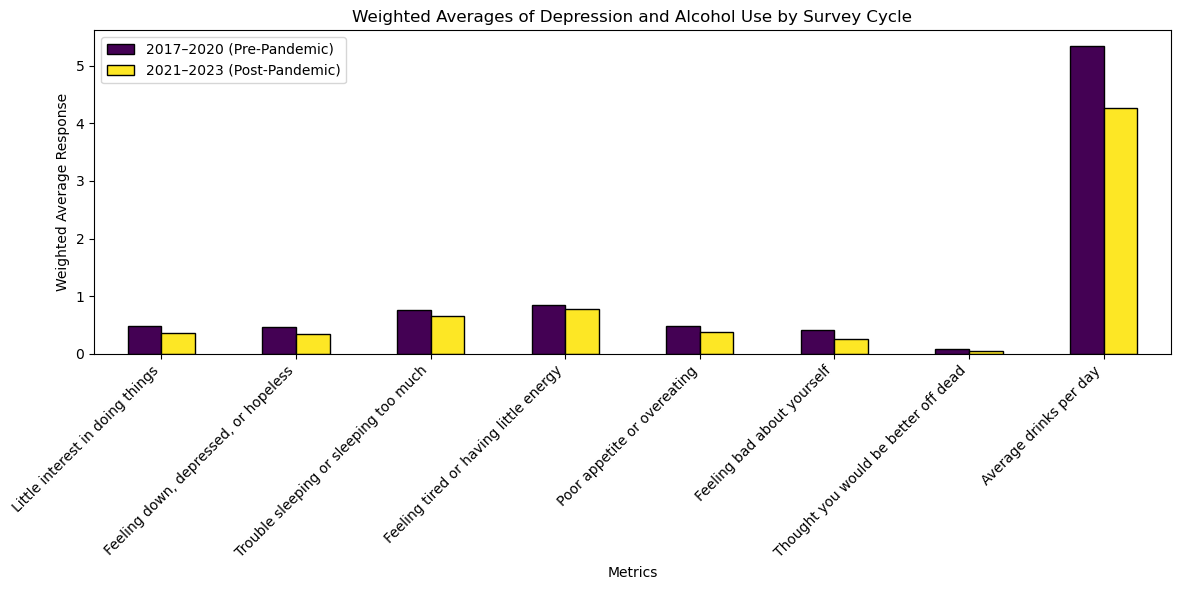

In [86]:
# Bar plot for weighted averages
weighted_means.plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title("Weighted Averages of Depression and Alcohol Use by Survey Cycle")
plt.xlabel("Metrics")
plt.ylabel("Weighted Average Response")
plt.legend(["2017–2020 (Pre-Pandemic)", "2021–2023 (Post-Pandemic)"], loc='upper left')
plt.tight_layout()
plt.show()


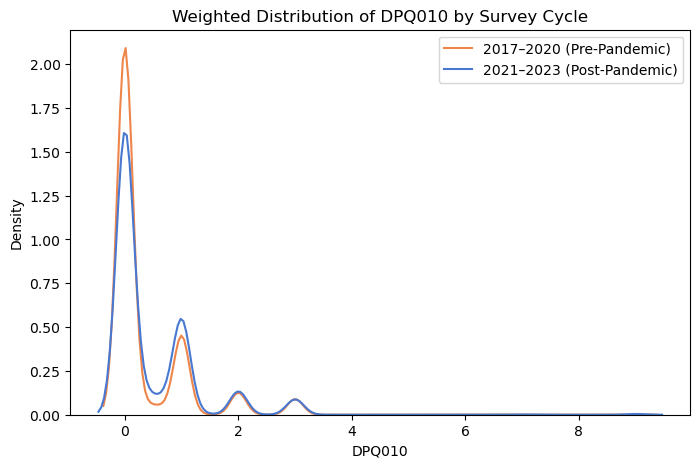

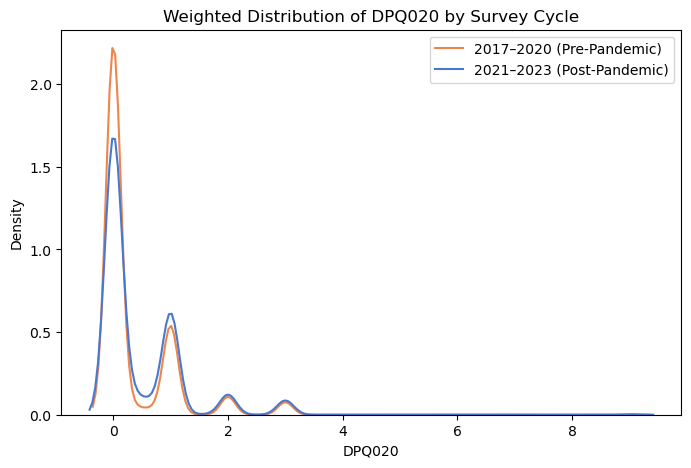

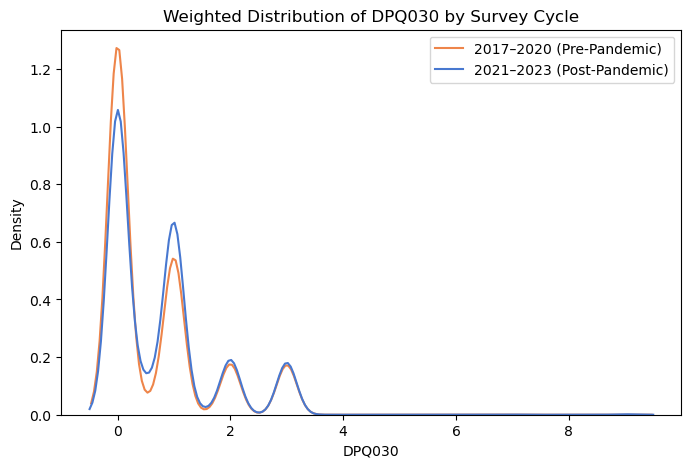

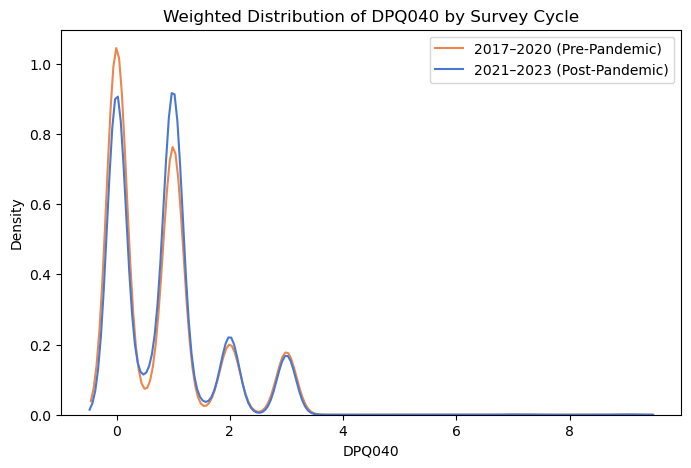

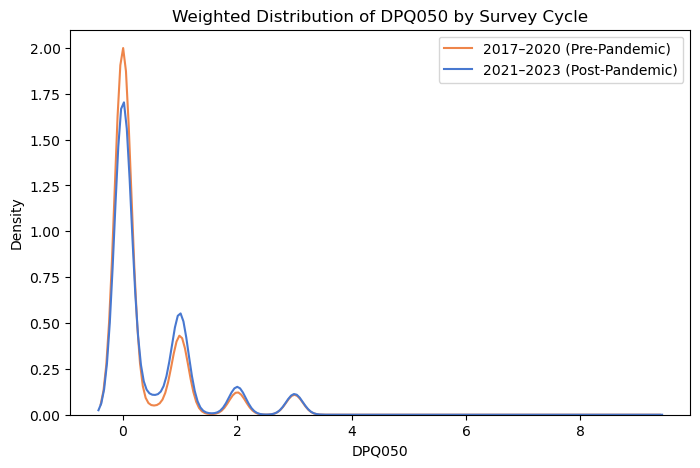

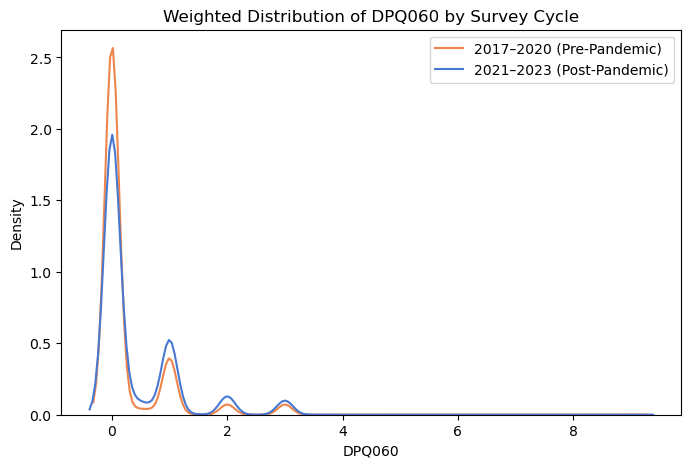

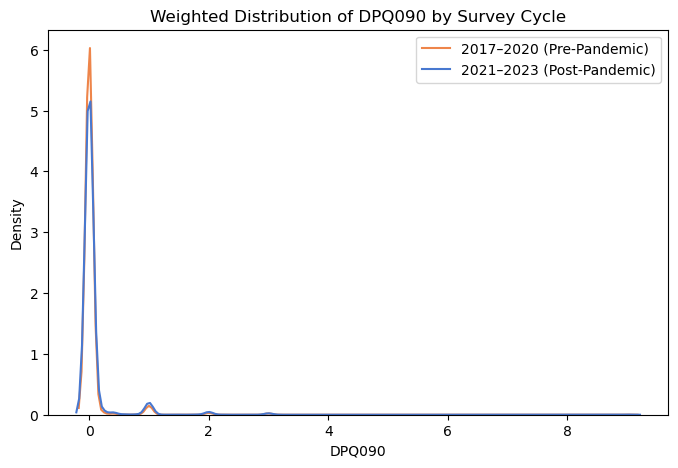

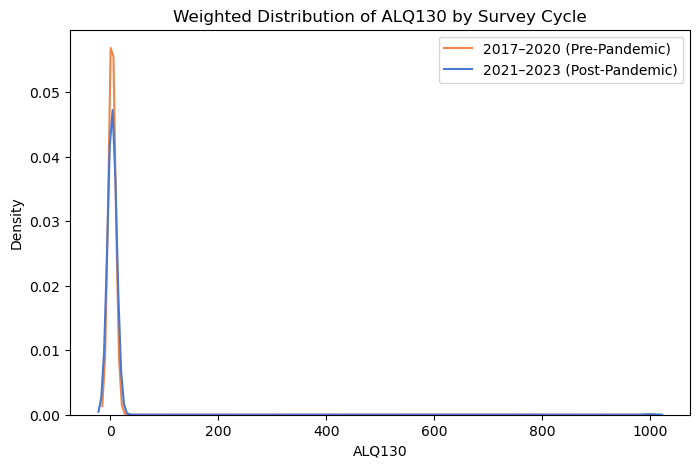

In [88]:
for col in analysis_columns:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(
        data=cleaned_data, x=col, hue="SDDSRVYR", weights="Consolidated_Weight", common_norm=False, palette="muted"
    )
    plt.title(f"Weighted Distribution of {col} by Survey Cycle")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend(["2017–2020 (Pre-Pandemic)", "2021–2023 (Post-Pandemic)"])
    plt.show()


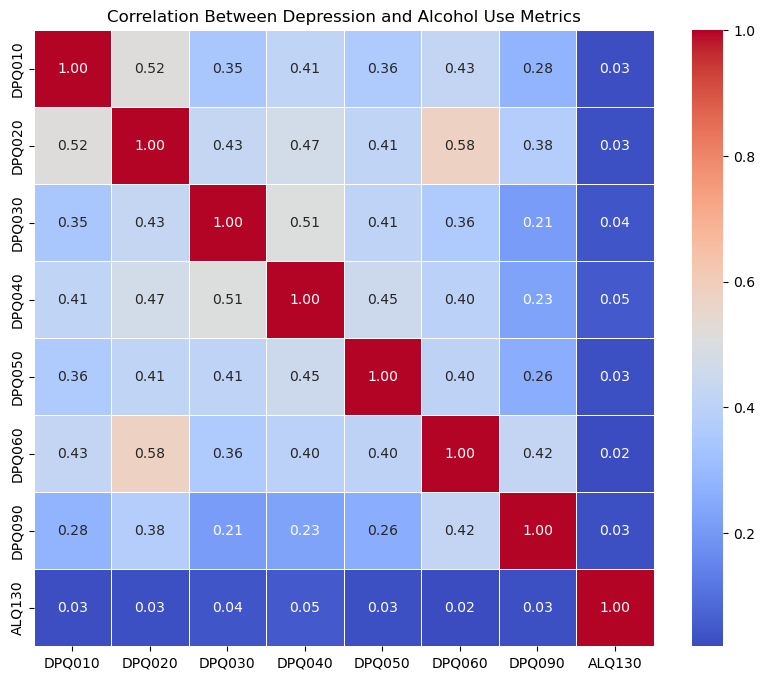

In [91]:
# Weighted correlation matrix
weighted_corr = [analysis_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(weighted_corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between Depression and Alcohol Use Metrics")
plt.show()


In [92]:
# Check total weight for each survey cycle
total_weights = cleaned_data.groupby('SDDSRVYR')['Consolidated_Weight'].sum()
total_respondents = cleaned_data.groupby('SDDSRVYR').size()

print("Total Weights by Survey Cycle:")
print(total_weights)

print("\nTotal Respondents by Survey Cycle:")
print(total_respondents)


Total Weights by Survey Cycle:
SDDSRVYR
12.0    1.952099e+08
66.0    2.295824e+08
Name: Consolidated_Weight, dtype: float64

Total Respondents by Survey Cycle:
SDDSRVYR
12.0    6337
66.0    8965
dtype: int64


In [93]:
# Group data by survey cycle and gender/race
grouped_gender = cleaned_data.groupby(['SDDSRVYR', 'RIAGENDR']).apply(
    lambda x: pd.Series({
        'Weighted_Depression': (x['DPQ010'] * x['Consolidated_Weight']).sum() / x['Consolidated_Weight'].sum(),
        'Weighted_Alcohol_Use': (x['ALQ130'] * x['Consolidated_Weight']).sum() / x['Consolidated_Weight'].sum(),
    })
).reset_index()

grouped_race = cleaned_data.groupby(['SDDSRVYR', 'RIDRETH1']).apply(
    lambda x: pd.Series({
        'Weighted_Depression': (x['DPQ010'] * x['Consolidated_Weight']).sum() / x['Consolidated_Weight'].sum(),
        'Weighted_Alcohol_Use': (x['ALQ130'] * x['Consolidated_Weight']).sum() / x['Consolidated_Weight'].sum(),
    })
).reset_index()

# Map gender and race codes for readability
gender_mapping = {1: "Male", 2: "Female"}
race_mapping = {
    1: "Mexican American",
    2: "Other Hispanic",
    3: "Non-Hispanic White",
    4: "Non-Hispanic Black",
    5: "Other Race - Including Multi-Racial"
}

grouped_gender['RIAGENDR'] = grouped_gender['RIAGENDR'].replace(gender_mapping)
grouped_race['RIDRETH1'] = grouped_race['RIDRETH1'].replace(race_mapping)


/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0000gn/T/ipykernel_77940/3708742659.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_gender = cleaned_data.groupby(['SDDSRVYR', 'RIAGENDR']).apply(
/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0000gn/T/ipykernel_77940/3708742659.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_race = cleaned_data.groupby(['SDDSRVYR', 'RIDRETH1']).apply(


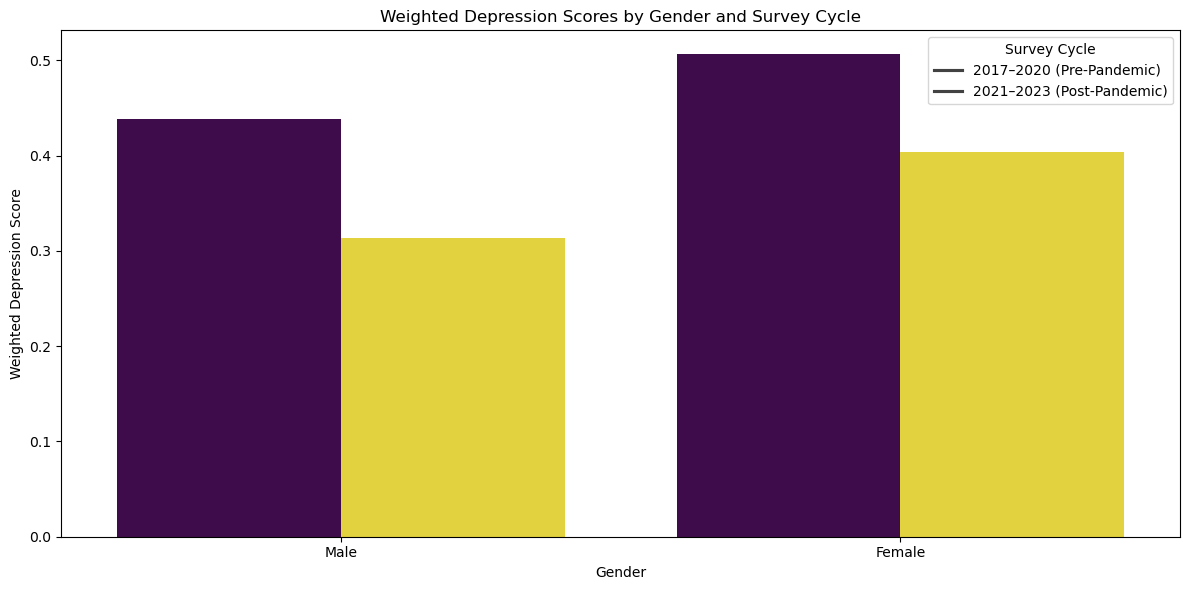

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot for gender comparisons
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_gender, x='RIAGENDR', y='Weighted_Depression', hue='SDDSRVYR', palette='viridis'
)
plt.title("Weighted Depression Scores by Gender and Survey Cycle")
plt.xlabel("Gender")
plt.ylabel("Weighted Depression Score")
plt.legend(title="Survey Cycle", labels=["2017–2020 (Pre-Pandemic)", "2021–2023 (Post-Pandemic)"])
plt.tight_layout()
plt.show()


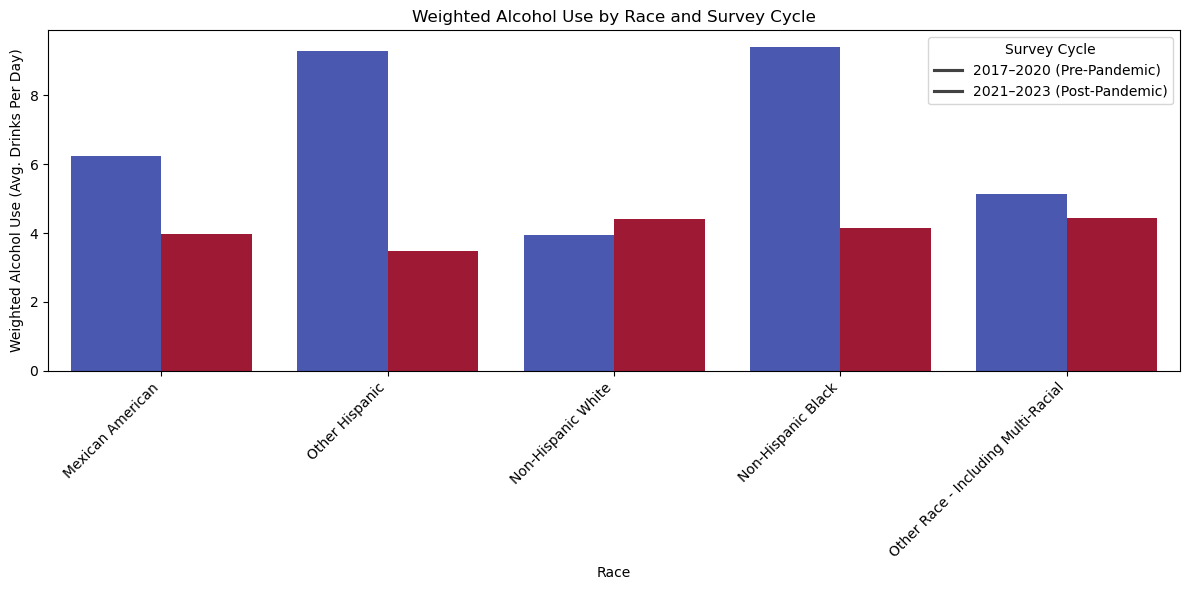

In [95]:
# Bar plot for race comparisons
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_race, x='RIDRETH1', y='Weighted_Alcohol_Use', hue='SDDSRVYR', palette='coolwarm'
)
plt.title("Weighted Alcohol Use by Race and Survey Cycle")
plt.xlabel("Race")
plt.ylabel("Weighted Alcohol Use (Avg. Drinks Per Day)")
plt.legend(title="Survey Cycle", labels=["2017–2020 (Pre-Pandemic)", "2021–2023 (Post-Pandemic)"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [96]:
from scipy.stats import ttest_ind

# T-test for gender depression scores
male_depression = cleaned_data.loc[cleaned_data['RIAGENDR'] == 1, 'DPQ010']
female_depression = cleaned_data.loc[cleaned_data['RIAGENDR'] == 2, 'DPQ010']

t_stat, p_value = ttest_ind(male_depression.dropna(), female_depression.dropna())
print(f"T-test for Depression Scores by Gender: T-stat = {t_stat:.2f}, P-value = {p_value:.3f}")


T-test for Depression Scores by Gender: T-stat = -5.84, P-value = 0.000


In [97]:
from scipy.stats import f_oneway

# ANOVA for alcohol use across race groups
alcohol_by_race = [cleaned_data.loc[cleaned_data['RIDRETH1'] == r, 'ALQ130'].dropna() for r in race_mapping.keys()]

f_stat, p_value = f_oneway(*alcohol_by_race)
print(f"ANOVA for Alcohol Use by Race: F-stat = {f_stat:.2f}, P-value = {p_value:.3f}")


ANOVA for Alcohol Use by Race: F-stat = 1.01, P-value = 0.403


/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0000gn/T/ipykernel_77940/3635287833.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gender_alcohol = cleaned_data.groupby(['SDDSRVYR', 'RIAGENDR']).apply(


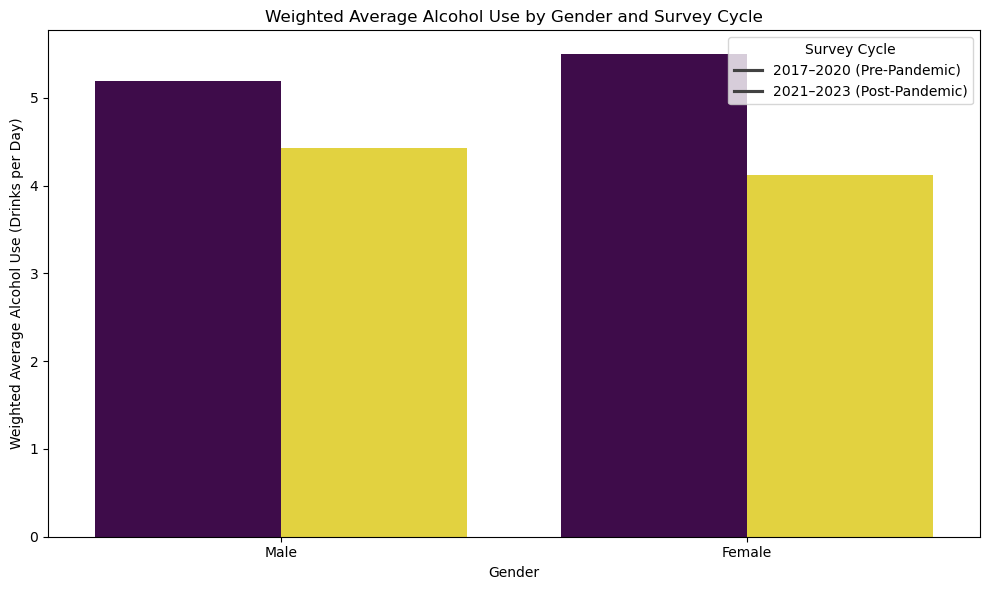

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Weighted averages of alcohol use by gender
gender_alcohol = cleaned_data.groupby(['SDDSRVYR', 'RIAGENDR']).apply(
    lambda x: (x['ALQ130'] * x['Consolidated_Weight']).sum() / x['Consolidated_Weight'].sum()
).reset_index(name='Weighted_Avg_Alcohol_Use')

# Map gender values
gender_mapping = {1: "Male", 2: "Female"}
gender_alcohol['RIAGENDR'] = gender_alcohol['RIAGENDR'].replace(gender_mapping)

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=gender_alcohol, x='RIAGENDR', y='Weighted_Avg_Alcohol_Use', hue='SDDSRVYR', palette='viridis')
plt.title("Weighted Average Alcohol Use by Gender and Survey Cycle")
plt.xlabel("Gender")
plt.ylabel("Weighted Average Alcohol Use (Drinks per Day)")
plt.legend(title="Survey Cycle", labels=["2017–2020 (Pre-Pandemic)", "2021–2023 (Post-Pandemic)"])
plt.tight_layout()
plt.show()


/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0000gn/T/ipykernel_77940/3452571674.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  race_depression = cleaned_data.groupby(['SDDSRVYR', 'RIDRETH1']).apply(


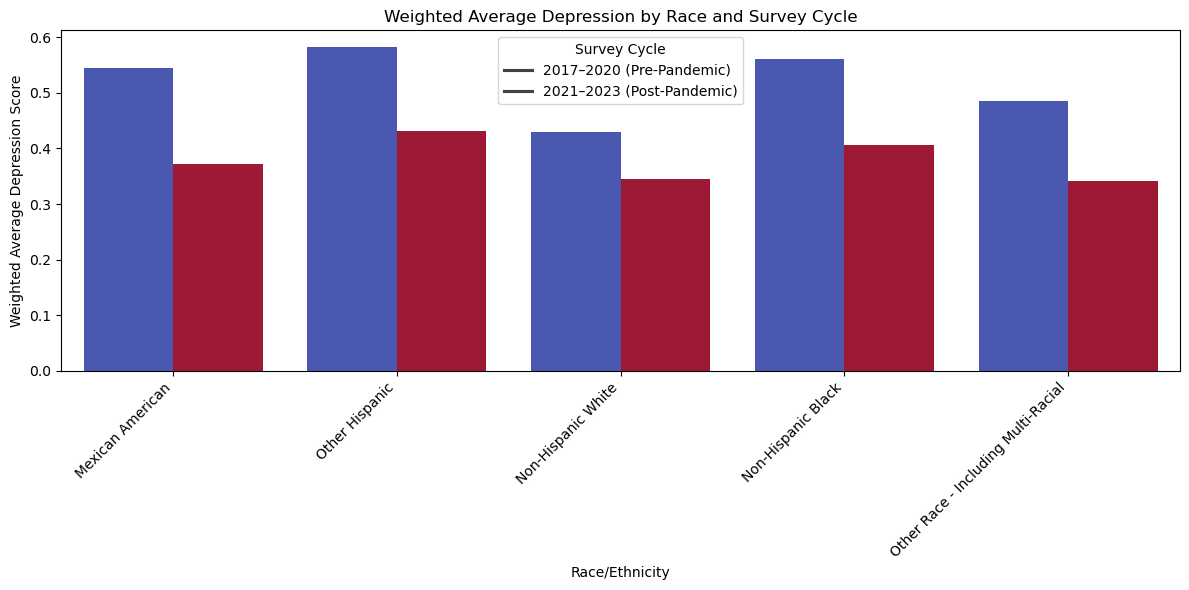

In [99]:
# Weighted averages of depression by race
race_depression = cleaned_data.groupby(['SDDSRVYR', 'RIDRETH1']).apply(
    lambda x: (x['DPQ010'] * x['Consolidated_Weight']).sum() / x['Consolidated_Weight'].sum()
).reset_index(name='Weighted_Avg_Depression')

# Map race values
race_mapping = {
    1: "Mexican American", 2: "Other Hispanic", 3: "Non-Hispanic White",
    4: "Non-Hispanic Black", 5: "Other Race - Including Multi-Racial"
}
race_depression['RIDRETH1'] = race_depression['RIDRETH1'].replace(race_mapping)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=race_depression, x='RIDRETH1', y='Weighted_Avg_Depression', hue='SDDSRVYR', palette='coolwarm')
plt.title("Weighted Average Depression by Race and Survey Cycle")
plt.xlabel("Race/Ethnicity")
plt.ylabel("Weighted Average Depression Score")
plt.legend(title="Survey Cycle", labels=["2017–2020 (Pre-Pandemic)", "2021–2023 (Post-Pandemic)"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Summary of trends:

It appears depression metrics ”feeling down, depressed, or hopeless" and "thought you would be better off dead,” showed lower average scores after the pandemic. This seems to show a decline in reported depression levels after the pandemic. 

At the same time, Average alcohol use metrics, such as the number of drinks per day also went down post-pandemic. “number of days had 4/5 drinks in the past 12 months" which measure heavy episodic drinking also showed a downward trends.

## Did the pandemic have a positive influence?

It would not be my first guess that a global pandemic had a positive outcome on depression and alcohol use stats, I’d like to continue by exploring two possible factors. First, noticing the sample size for the post pandemic survey is app 2k fewer people which might lead to sample issues. The weights are meant to account for sample size differences but I’d like to confirm. The most severely affected individuals during the pandemic might not be represented in the post-pandemic survey data.
 
Second it’s possible the pandemic brought more focus to mental health and coping mechanisms or better access to mental health resources, which could impact mental health positively. Alcohol use may have indeed reduced as people shifted from social drinking out of their homes to other habits. 

## To understand better 

I'll calculate total weights for each survey cycle  in the Consolidated_Weight column and compare them to see if totals are proportionate to the population being represented, not just the sample size. I'll also try comparing weighted vs. unweighted averages for depression and alcohol use metrics to see if weighting alters the results.



In [100]:
# Calculate total weights for each survey cycle
total_weights_by_cycle = cleaned_data.groupby('SDDSRVYR')['Consolidated_Weight'].sum()

# Print results
print("Total Weights by Survey Cycle:")
print(total_weights_by_cycle)


Total Weights by Survey Cycle:
SDDSRVYR
12.0    1.952099e+08
66.0    2.295824e+08
Name: Consolidated_Weight, dtype: float64


In [101]:
# Metrics to compare
metrics = ['DPQ020', 'DPQ090', 'ALQ130', 'ALQ142']

# Function for weighted mean
def weighted_mean(data, value_col, weight_col):
    return (data[value_col] * data[weight_col]).sum() / data[weight_col].sum()

# Calculate weighted and unweighted averages
averages = {}
for metric in metrics:
    weighted_avg = cleaned_data.groupby('SDDSRVYR').apply(
        lambda x: weighted_mean(x, metric, 'Consolidated_Weight')
    )
    unweighted_avg = cleaned_data.groupby('SDDSRVYR')[metric].mean()
    averages[metric] = {'Weighted': weighted_avg, 'Unweighted': unweighted_avg}

# Convert results to a DataFrame
comparison_df = pd.DataFrame.from_dict(averages, orient='index')
print(comparison_df)


                                                 Weighted  \
DPQ020  SDDSRVYR
12.0    0.461975
66.0    0.341079
dty...   
DPQ090  SDDSRVYR
12.0    0.074076
66.0    0.050094
dty...   
ALQ130  SDDSRVYR
12.0    5.347949
66.0    4.265741
dty...   
ALQ142  SDDSRVYR
12.0    4.606541
66.0    3.716456
dty...   

                                               Unweighted  
DPQ020  SDDSRVYR
12.0    0.467855
66.0    0.376375
Nam...  
DPQ090  SDDSRVYR
12.0    0.079817
66.0    0.059364
Nam...  
ALQ130  SDDSRVYR
12.0    5.468809
66.0    4.403157
Nam...  
ALQ142  SDDSRVYR
12.0    4.363980
66.0    3.492008
Nam...  


/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0000gn/T/ipykernel_77940/3250648279.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = cleaned_data.groupby('SDDSRVYR').apply(
/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw0000gn/T/ipykernel_77940/3250648279.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = cleaned_data.groupby('SDDSRVYR').apply(
/var/folders/zy/xwgq7lw55ws4l7jc1x1tmcdw00

In [117]:

import praw

# Reddit API credentials
reddit = praw.Reddit(
    client_id="fGpurrNi_EtyMWJrYgLwXA", 
    client_secret="8x_7nhyd1t5MEFgB92cB766X562CtQ", 
    user_agent="Alcohol-Health-Data-Analysis by /u/ThatDog_ThisDog"
)

keywords = ["alcoholism", "quitting", "IWNDWYT", "drinking", "booze", "beer", "quit", "mental health", "meditation", "therapy", "therapist"]


In [118]:
import pandas as pd

# List of subreddits
subreddits = ["AskReddit", "stopdrinking", "Health"]

# Function to fetch Reddit posts
def fetch_posts(subreddit, limit=1000):
    subreddit_data = reddit.subreddit(subreddit)
    posts = []
    for submission in subreddit_data.top(limit=limit):  # Fetch top posts (adjust to your needs)
        if any(keyword in submission.title.lower() or keyword in submission.selftext.lower() for keyword in keywords):
            posts.append({
                "subreddit": subreddit,
                "title": submission.title,
                "selftext": submission.selftext,
                "created_utc": submission.created_utc
            })
    return posts

# Fetch posts for each subreddit
all_posts = []
for sub in subreddits:
    all_posts.extend(fetch_posts(sub, limit=1000))

# Convert to DataFrame
reddit_df = pd.DataFrame(all_posts)
reddit_df["created_utc"] = pd.to_datetime(reddit_df["created_utc"], unit="s")  # Convert timestamps
reddit_df.to_csv("reddit_posts_filtered.csv", index=False)
print("Fetched posts saved to reddit_posts_filtered.csv")


Fetched posts saved to reddit_posts_filtered.csv


In [119]:

import requests

def fetch_pushshift(subreddit, keywords, start_date, end_date):
    url = f"https://api.pushshift.io/reddit/search/submission/"
    params = {
        "subreddit": subreddit,
        "q": "|".join(keywords),  # OR search for keywords
        "after": start_date,
        "before": end_date,
        "size": 1000,  # Number of posts per request
    }
    response = requests.get(url, params=params)
    return response.json().get("data", [])

# Example usage
start_date = "2017-01-01"
end_date = "2023-12-31"

all_pushshift_posts = []
for sub in subreddits:
    all_pushshift_posts.extend(fetch_pushshift(sub, keywords, start_date, end_date))

pushshift_df = pd.DataFrame(all_pushshift_posts)
pushshift_df.to_csv("pushshift_reddit_posts.csv", index=False)
print("Historical posts saved to pushshift_reddit_posts.csv")


Historical posts saved to pushshift_reddit_posts.csv


<Axes: title={'center': 'Keyword Mentions Over Time'}, xlabel='year', ylabel='Mentions'>

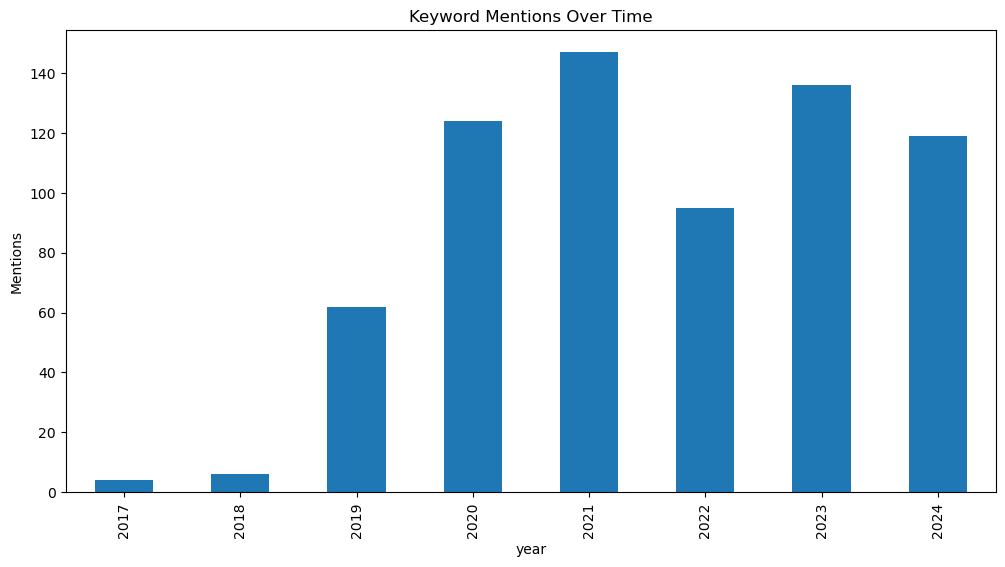

In [120]:
reddit_df["year"] = reddit_df["created_utc"].dt.year
keyword_counts = reddit_df.groupby("year").size()

# Plotting
keyword_counts.plot(kind="bar", title="Keyword Mentions Over Time", figsize=(12, 6), ylabel="Mentions")


<Axes: title={'center': 'Mentions by Subreddit'}, xlabel='subreddit', ylabel='Mentions'>

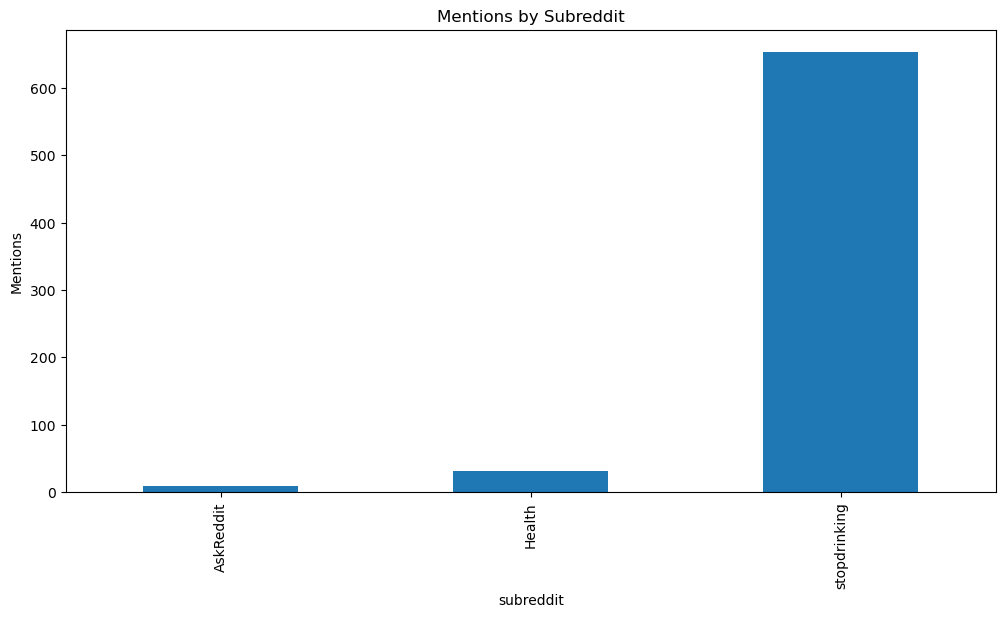

In [121]:
subreddit_counts = reddit_df.groupby("subreddit").size()

# Plotting
subreddit_counts.plot(kind="bar", title="Mentions by Subreddit", figsize=(12, 6), ylabel="Mentions")


In [123]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download("stopwords")
nltk.download("punkt")

stop_words = set(stopwords.words("english"))
text_data = " ".join(reddit_df["selftext"].dropna())
tokens = word_tokenize(text_data.lower())
filtered_words = [word for word in tokens if word.isalpha() and word not in stop_words]

word_counts = Counter(filtered_words)
print(word_counts.most_common(20))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pozlong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pozlong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('drinking', 1010), ('day', 696), ('time', 611), ('drink', 605), ('like', 585), ('one', 573), ('sober', 526), ('life', 505), ('alcohol', 494), ('would', 484), ('years', 468), ('get', 447), ('could', 431), ('much', 414), ('know', 398), ('days', 389), ('got', 370), ('every', 360), ('going', 356), ('today', 355)]


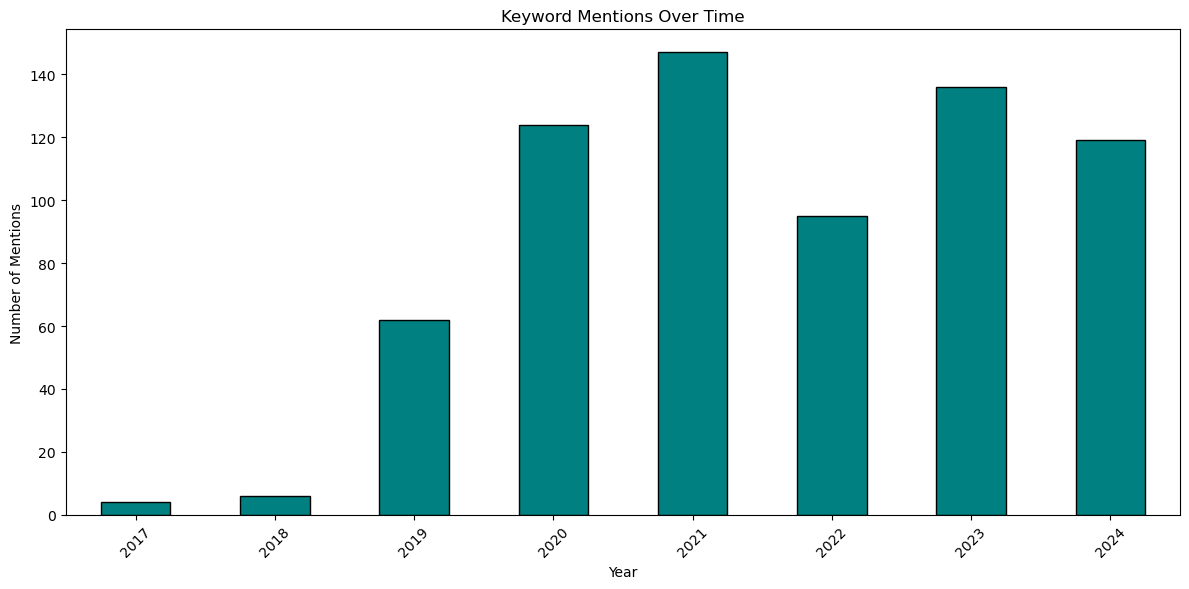

In [124]:
import matplotlib.pyplot as plt

# Extract year from the timestamp
reddit_df["year"] = reddit_df["created_utc"].dt.year

# Count keyword mentions per year
keyword_trends = reddit_df.groupby("year").size()

# Plot the trends
plt.figure(figsize=(12, 6))
keyword_trends.plot(kind="bar", color="teal", edgecolor="black")
plt.title("Keyword Mentions Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


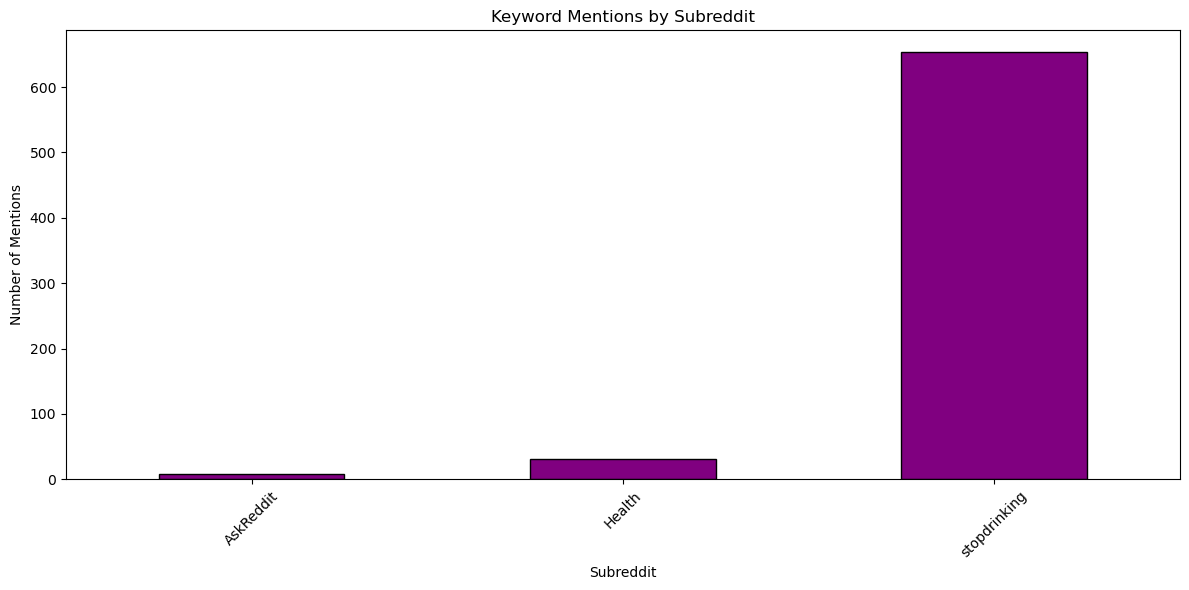

In [125]:
# Count mentions by subreddit
subreddit_counts = reddit_df.groupby("subreddit").size()

# Plot the subreddit counts
plt.figure(figsize=(12, 6))
subreddit_counts.plot(kind="bar", color="purple", edgecolor="black")
plt.title("Keyword Mentions by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Number of Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pozlong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pozlong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


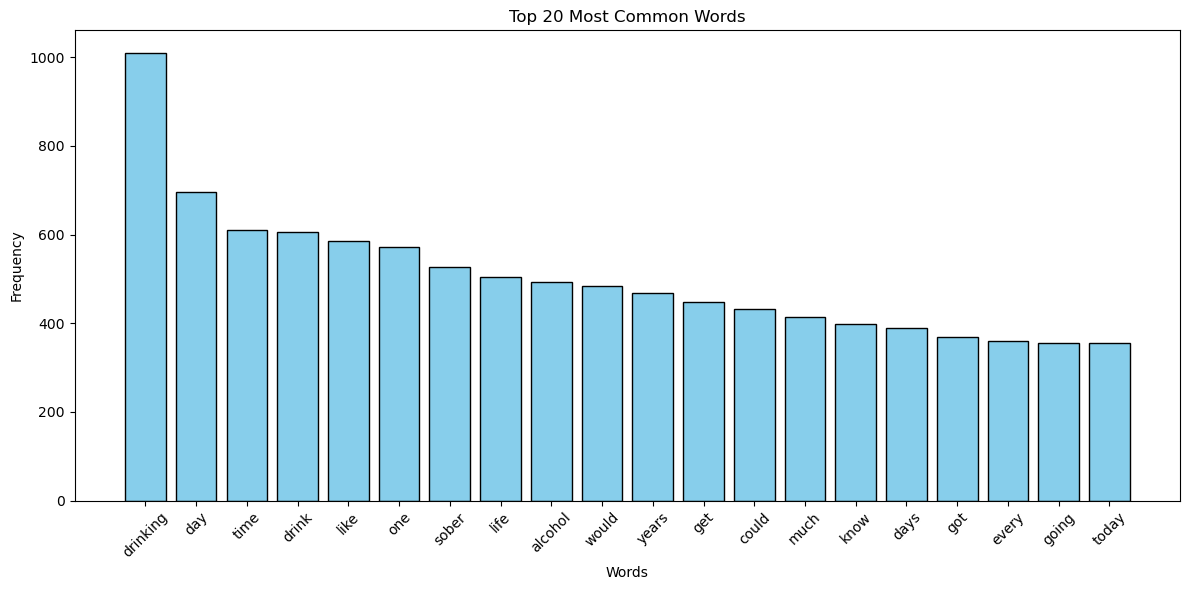

In [126]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download("stopwords")
nltk.download("punkt")

# Tokenize and remove stopwords
stop_words = set(stopwords.words("english"))
tokens = word_tokenize(text_data.lower())
filtered_words = [word for word in tokens if word.isalpha() and word not in stop_words]

# Count the top 20 most common words
word_counts = Counter(filtered_words)
top_words = word_counts.most_common(20)

# Prepare data for plotting
words, counts = zip(*top_words)

# Plot the word frequencies
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="skyblue", edgecolor="black")
plt.title("Top 20 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


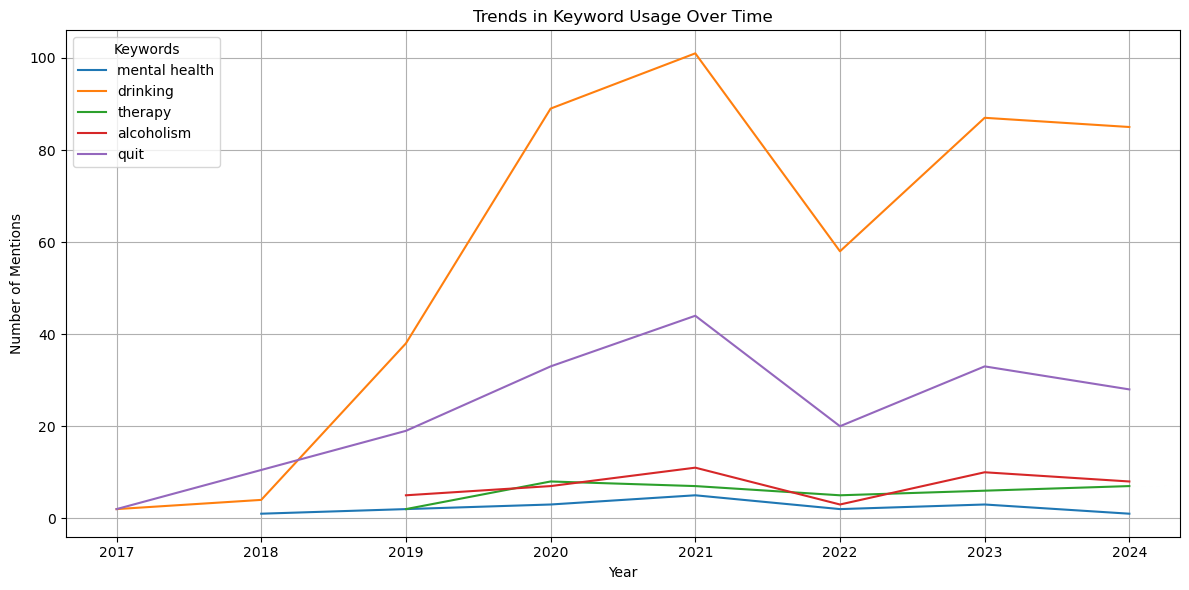

In [127]:
# Function to count keyword occurrences per year
def keyword_trend(keyword):
    return reddit_df[reddit_df["selftext"].str.contains(keyword, case=False, na=False)].groupby("year").size()

# Keywords to track
keywords = ["mental health", "drinking", "therapy", "alcoholism", "quit"]

# Count mentions per year for each keyword
keyword_counts = {kw: keyword_trend(kw) for kw in keywords}

# Create a line plot
plt.figure(figsize=(12, 6))
for kw, counts in keyword_counts.items():
    counts.plot(label=kw)

plt.title("Trends in Keyword Usage Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Mentions")
plt.legend(title="Keywords")
plt.grid(True)
plt.tight_layout()
plt.show()
